## Importing libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitz
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Data loading

In [55]:
train_df = pd.read_csv('extracted_data.csv')

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   datasheet_link  1895 non-null   object
 1   target_col      1895 non-null   object
 2   extracted_text  912 non-null    object
dtypes: object(3)
memory usage: 44.5+ KB


In [57]:
df_new = pd.read_csv('file1.csv')

In [58]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1894 non-null   int64 
 1   datasheet_link  1894 non-null   object
 2   target_col      1894 non-null   object
 3   extracted_text  916 non-null    object
dtypes: int64(1), object(3)
memory usage: 59.3+ KB


##  Data concatination

In [59]:
df = pd.concat([train_df, df_new], axis=0)

## Basic EDA

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3789 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datasheet_link  3789 non-null   object 
 1   target_col      3789 non-null   object 
 2   extracted_text  1828 non-null   object 
 3   Unnamed: 0      1894 non-null   float64
dtypes: float64(1), object(3)
memory usage: 148.0+ KB


In [61]:
df.duplicated().sum()

694

In [62]:
df.drop_duplicates(inplace=True)

In [63]:
df.duplicated().sum()

0

In [64]:
df.dropna(inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datasheet_link  916 non-null    object 
 1   target_col      916 non-null    object 
 2   extracted_text  916 non-null    object 
 3   Unnamed: 0      916 non-null    float64
dtypes: float64(1), object(3)
memory usage: 35.8+ KB


In [66]:
train_df = df

In [67]:
train_df.dropna(inplace=True)

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datasheet_link  916 non-null    object 
 1   target_col      916 non-null    object 
 2   extracted_text  916 non-null    object 
 3   Unnamed: 0      916 non-null    float64
dtypes: float64(1), object(3)
memory usage: 35.8+ KB


In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 1893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datasheet_link  916 non-null    object 
 1   target_col      916 non-null    object 
 2   extracted_text  916 non-null    object 
 3   Unnamed: 0      916 non-null    float64
dtypes: float64(1), object(3)
memory usage: 35.8+ KB


In [70]:
train_df['target_col'].value_counts()

target_col
fuses       464
lighting    220
cable       129
others      103
Name: count, dtype: int64

## Text Preprocessing 

In [71]:
!  pip install contractions


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import string
import unicodedata
import contractions
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()    
    # Expand contractions
    text = contractions.fix(text)   
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)  
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))   
    # Remove numbers
    text = ''.join([char for char in text if not char.isdigit()])  
    # Tokenization
    tokens = word_tokenize(text)  
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
     # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    # Remove extra whitespace
    text = ' '.join(tokens)
    
    return text


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:
train_df['cleaned_text'] = train_df['extracted_text'].apply(preprocess_text)

In [74]:
train_df = train_df.reset_index(drop=True)

In [75]:
link = train_df['datasheet_link'].str.split('/').str[2:]

In [76]:
train_df.insert(2, 'key_link', link)

In [77]:
train_df.insert(5, 'classes', train_df['target_col'])

In [78]:
train_df.shape

(916, 7)

In [79]:
train_df.drop(columns=['target_col'],inplace=True)

In [80]:
train_df['key_link'] = train_df['key_link'].apply(lambda x: '/'.join(x))

In [81]:
def remove_www(url):
    # Check if "www" is present in the URL
    if 'www.' in url:
        # Remove "www." from the URL
        return url.replace('www.', '')
    else:
        # Return the URL unchanged if "www" is not present
        return url

# Apply this function to the 'datasheet_link' column
train_df['key_link'] = train_df['key_link'].apply(remove_www)

In [82]:
domain = train_df['key_link'].str.split('.').str[:1]

In [83]:
train_df.insert(2, 'domain', domain)

In [84]:
train_df['domain'] = train_df['domain'].apply(lambda x: ''.join(x))

In [85]:
link_fea2 = train_df['key_link'].str.split('.').str[1:2].apply(lambda x: ''.join(x)).str.split('/').str[-1]

In [86]:
train_df.insert(3,'link_fea2', link_fea2)

In [87]:
train_df['unique_word'] = train_df['cleaned_text'].apply(lambda x: len(set(x.split())))


In [88]:
train_df.columns

Index(['datasheet_link', 'key_link', 'domain', 'link_fea2', 'extracted_text',
       'Unnamed: 0', 'classes', 'cleaned_text', 'unique_word'],
      dtype='object')

In [89]:
! pip install nltk



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import nltk

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [91]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import joblib

In [92]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(train_df['cleaned_text']).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())
train_df = pd.concat([train_df, tfidf_df], axis=1)
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl')

print(train_df.head())

                                      datasheet_link  \
0  https://lfillumination.com/files/specsheets/EF...   
1  https://lfillumination.com/files/specsheets/EF...   
2  https://www.waclighting.com/storage/waclightin...   
3  https://lfillumination.com/files/specsheets/KA...   
4  https://lfillumination.com/files/specsheets/JU...   

                                            key_link          domain  \
0  lfillumination.com/files/specsheets/EF408B-Lig...  lfillumination   
1  lfillumination.com/files/specsheets/EF407B-Lig...  lfillumination   
2  waclighting.com/storage/waclighting-images/spe...     waclighting   
3  lfillumination.com/files/specsheets/KATRPB-Pen...  lfillumination   
4  lfillumination.com/files/specsheets/JULRPB-Pen...  lfillumination   

           link_fea2                                     extracted_text  \
0  EF408B-Light-Unit  EF400 System # EF408B\nDIE CAST CYLINDRICAL LI...   
1  EF407B-Light-Unit  EF400 System # EF407B\nDIE CAST CYLINDRICAL LI...   
2    

In [93]:
X = train_df.drop(columns=['datasheet_link', 'key_link', 'domain', 'link_fea2', 'extracted_text','Unnamed: 0',
       'cleaned_text', 'classes', 'unique_word'])

In [94]:
X

,aa,ability,ac,acc,accent,accessory,accommodate,accordance,according,accuguard,...,xxxx,year,yes,zhukhyk,zjo,zl,zly,zonal,zone,μm
0,0.0,0.000000,0.0,0.0,0.073757,0.038779,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.102283,0.053777,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.009664,0.0,0.0,0.000000,0.009776,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.078516,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.062726,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
912,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
914,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['classes'] = le.fit_transform(train_df['classes'])

In [96]:
y = train_df['classes']

In [97]:
y.value_counts()

classes
1    464
2    220
0    129
3    103
Name: count, dtype: int64

In [98]:
! pip install imbalanced-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Model Training

### Random Forest

In [99]:
test_data = pd.read_csv('extracted_test_data.csv')
test_data.dropna(inplace=True)
test_data['classes'] = le.transform(test_data['target_col'])
test_data['cleaned_data']  = test_data['extracted_text'].apply(preprocess_text)
# tfidf_test = vectorizer.transform(test_data['cleaned_data
# train_df['classes'] = le.fit_transform(train_df['classes'])
tfidf_features = tfidf_vectorizer.transform(test_data['cleaned_data']).toarray()

In [100]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split your data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Apply SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X, y)

# Train the model
model = RandomForestClassifier(class_weight='balanced',
    n_estimators=10,        # Increased number of trees for robustness
    max_depth=8,            # Limit the depth of each tree
    min_samples_split=3,     # Minimum samples required to split an internal node
    min_samples_leaf=3 )
model.fit(X_train_smote, y_train_smote)

# # Evaluate the model
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))


RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=10)

In [101]:
train_accuracy = model.score(X, y)
train_accuracy

0.9978165938864629

In [102]:
test_data.columns

Index(['datasheet_link', 'target_col', 'extracted_text', 'classes',
       'cleaned_data'],
      dtype='object')

In [103]:
y_pred1 = model.predict(tfidf_features)

y_act = test_data['classes'].dropna().reset_index(drop=True)
accuracy_score(y_act, y_pred1)

C:\Users\aksha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7428571428571429

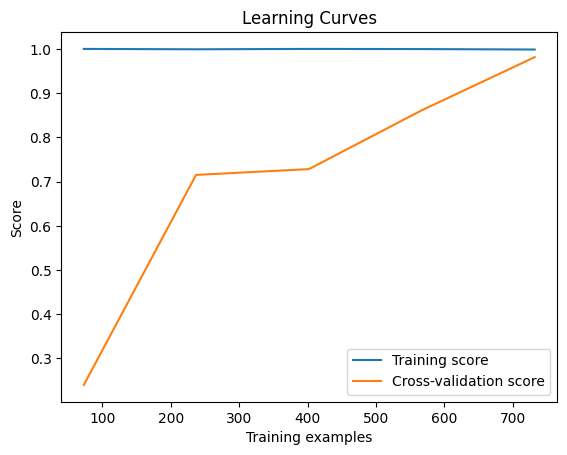

In [104]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curves")
plt.show()

##  Naive Bayes

In [105]:
from sklearn.naive_bayes import MultinomialNB
# Apply SMOTE
smote = SMOTE()
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X, y)

modelnb= MultinomialNB()
modelnb.fit(X_train_smote, y_train_smote)


MultinomialNB()

In [106]:
train_accuracy = modelnb.score(X, y)
train_accuracy

0.9978165938864629

In [107]:
y_pred = modelnb.predict(tfidf_features)

C:\Users\aksha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [109]:
y_act = test_data['classes'].dropna().reset_index(drop=True)
accuracy_score(y_act, y_pred)

0.7346938775510204

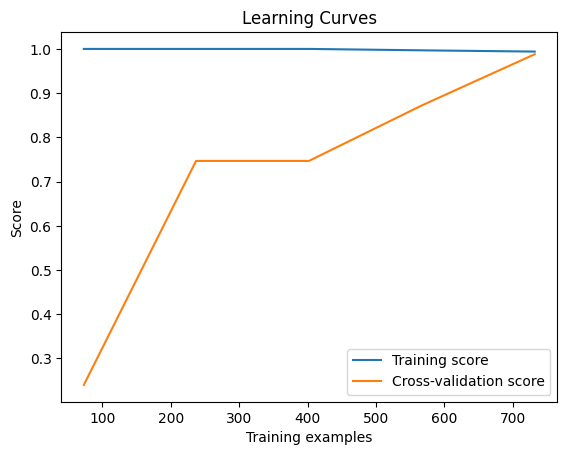

In [110]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(modelnb, X, y, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curves")
plt.show()

In [111]:
import joblib
# Save the trained model
joblib.dump(model, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

### SVC

In [112]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X, y)

# Standardize the data (SVMs often perform better with scaled data)
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
# X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(
    kernel='linear',      # You can try 'linear', 'rbf', 'poly', etc.
    C=1.0,                # Regularization parameter
    probability=True,     # To enable probability estimates
    class_weight='balanced'  # Handle class imbalance
)
model.fit(X_train_smote, y_train_smote)

SVC(class_weight='balanced', kernel='linear', probability=True)

In [113]:
train_accuracy = model.score(X, y)
train_accuracy

C:\Users\aksha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.35152838427947597